In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

Carregar o dataset de feijões 

In [2]:
# Carrega o dataset direto do Tensorflow
data, meta = tfds.load('beans',
                 as_supervised=True,
                 with_info=True,
                 )

In [3]:
# Extraindo os dados de treino, validação e teste
train, val, test = data['train'], data['validation'], data['test']

In [4]:
# Exemplo de dado
ex = next(iter(test))
ex[0].numpy()[0][0]

array([141, 152,  96], dtype=uint8)

In [5]:
# Função para normalizar os dados 
# com o intuito de melhorar a extração de features
# e padronizar as imagens
def normalize(image, label):
  image = tf.image.resize(((tf.cast(image, tf.float32))/255.0), (160,160))
  return image,label

In [6]:
# Normalizando os dados
train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

In [7]:
# Embaralhando os dados de treino e definindo o tamanho dos batchs de treino, validação e teste (64)
train_batch = train.shuffle(1000).batch(64)  
val_batch = val.batch(64)
test_batch = test.batch(64)

Criação do modelo

In [8]:
def create_network():

  # Max Pooling - Usado para realçar as features mais presentes nos dados
  # kernel_regularizer= l1_l2 - Regularizador que aplica penalidades nas camadas
  # com o intuito de atenuar o overfitting
  # Dropout - Técnica de regularização, reduz overfitting

  net = keras.models.Sequential([
                                  # Camadas intermediárias (corpo)
                                  keras.layers.Conv2D(64,(3,3), activation='relu',input_shape=[160,160,3]),
                                  keras.layers.MaxPooling2D((2,2)),
                                  keras.layers.Conv2D(128,(3,3),strides=2, activation='relu', kernel_regularizer='l1_l2'),
                                  keras.layers.MaxPooling2D((2,2)),
                                  keras.layers.Conv2D(128,(3,3),strides=2, activation='relu', kernel_regularizer='l1_l2'),
                                  # Camadas finais (cabeça)
                                  keras.layers.Flatten(),
                                  keras.layers.Dense(128,activation='relu'),
                                  keras.layers.Dropout(0.5),
                                  keras.layers.Dense(64,activation='relu'),
                                  keras.layers.Dense(3,activation='softmax')
                               ])
  return net
  
model = create_network()

In [9]:
# Informações do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 10368)             0

In [10]:
# Compilando o modelo, utilizando o otimizador Adam, loss function Sparse 
# Categorial Crossentropy, que calcula a entropia cruzada entre os labels
# e predições, e definindo como acurácia a métrica a ser avaliada.
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Treinando o modelo com 40 épocas (ciclos)
trained_model = model.fit(train_batch, validation_data=val_batch, epochs=40)

Epoch 1/40
17/17 [==============================] - 57s 3s/step - loss: 47.0528 - accuracy: 0.4091 - val_loss: 30.4293 - val_accuracy: 0.4286
Epoch 2/40
17/17 [==============================] - 44s 3s/step - loss: 20.9004 - accuracy: 0.5348 - val_loss: 11.6104 - val_accuracy: 0.3308
Epoch 3/40
17/17 [==============================] - 44s 3s/step - loss: 7.1571 - accuracy: 0.4362 - val_loss: 3.7101 - val_accuracy: 0.6090
Epoch 4/40
17/17 [==============================] - 43s 2s/step - loss: 2.8670 - accuracy: 0.5280 - val_loss: 2.0390 - val_accuracy: 0.6090
Epoch 5/40
17/17 [==============================] - 43s 2s/step - loss: 1.8268 - accuracy: 0.4903 - val_loss: 1.6112 - val_accuracy: 0.4436
Epoch 6/40
17/17 [==============================] - 43s 2s/step - loss: 1.4702 - accuracy: 0.5397 - val_loss: 1.3151 - val_accuracy: 0.5714
Epoch 7/40
17/17 [==============================] - 43s 2s/step - loss: 1.3153 - accuracy: 0.5764 - val_loss: 1.2850 - val_accuracy: 0.5188
Epoch 8/40
17/17

Análise de performance

In [12]:
# Transformando a lista com os resultados de perda em cada época em um DataFrame 
# do Pandas, para análise
history = pd.DataFrame(trained_model.history)

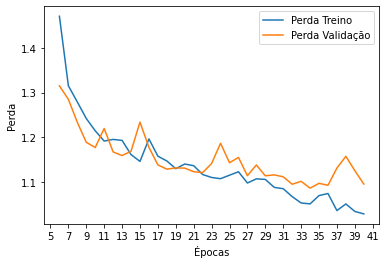

In [13]:
# Mostrando a perda de teste e treino em relação a cada época
epochs = np.arange(6,41)
plt.plot(epochs,history['loss'][5:], label='Perda Treino')
plt.plot(epochs,history['val_loss'][5:], label='Perda Validação')
plt.legend()
plt.ylabel('Perda')
plt.xlabel('Épocas')
plt.xticks(np.arange(5,42,2))
plt.show()

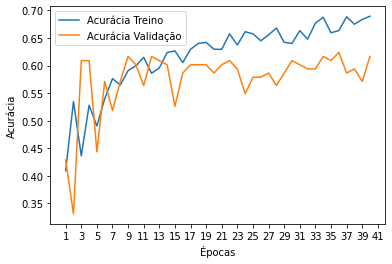

In [14]:
# Mostrando a acurácia de treino e validação em relação a cada época
epochs = np.arange(1,41)
plt.plot(epochs,history['accuracy'], label='Acurácia Treino')
plt.plot(epochs,history['val_accuracy'], label='Acurácia Validação')
plt.legend()
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.xticks(np.arange(1,42,2))
plt.show()

Predição nos dados de teste

In [17]:
# Realizando predição usando no batch de teste
predictions = model.predict(test_batch)


In [18]:
# Shape das predições
predictions.shape

(128, 3)

In [19]:
# Imagens e seus labels correspondentes do batch de teste
images,labels = next(iter(test_batch))

In [20]:
# Exemplo de shape de uma imagem
p = images[0]
print(p.shape)

(160, 160, 3)


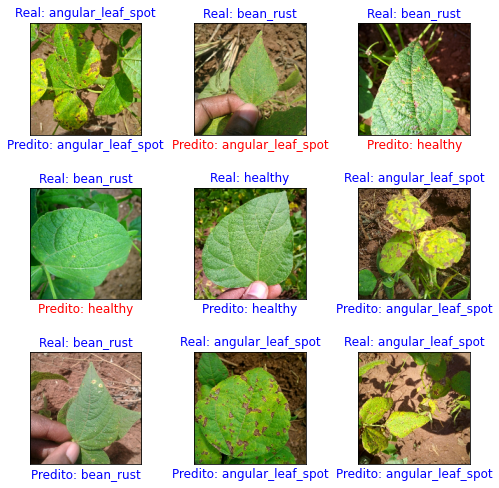

In [25]:
# Extraindo os rótulos das imagens
label_extractor = meta.features['label'].int2str

# Criando um plot
plt.figure(figsize=(7,7))

# Pegando um batch de teste 
batch = next(iter(test_batch))

# Plotando as imagens em um quadro de 3x3 
# com os rótulos originais e os preditos
for index in range(9):
  plt.subplot(3,3,index+1)
  pred = np.argmax(predictions[index])
  plt.title(f'Real: {label_extractor(labels[index])}' ,color='b',size=12)
  if pred==labels[index]:
    plt.xlabel(f'Predito: {label_extractor(pred)}', color='b',size=12)
  else:
    plt.xlabel(f'Predito: {label_extractor(pred)}', color='r',size=12)
  plt.imshow(images[index])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()